# Investigating Heat Transfer as a Function of Volume

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *
import pandas as pd
from scipy import stats
import numpy as np

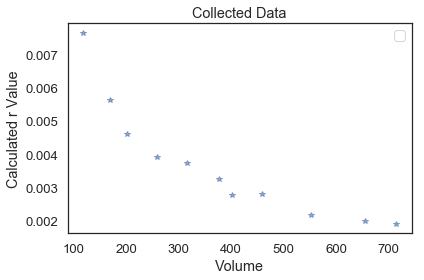

In [2]:
#A list of the data collected in our experiments. Each volume has a corresponding calculated r value
data = {'Volume': [118.354, 169.507,202.606,258.774,316.948,377.128,401.2,458.371,551.65,654.959,714.136,], 
             'r': [0.007660215,0.00563342,0.004614561,0.003912183,0.003744291,0.003259004,0.002769218,
                   0.002814454,0.002157224,0.001998175,0.001906878]}
#Creating a DataFrame from our collected data
r_vs_volume_data = pd.DataFrame(data=data);
plot(r_vs_volume_data['Volume'], r_vs_volume_data['r'], '*')
decorate(xlabel = 'Volume', ylabel = 'Calculated r Value', title = "Collected Data")

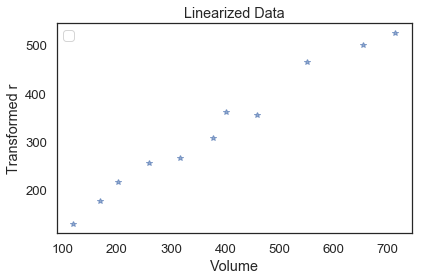

In [3]:
# In order to find a best fit curve, we first linearize the data in data2, then create r_vs_volume_transformed_data 
# as the DataFrame of these transformed linear values
data2 = {'Volume': r_vs_volume_data['Volume'], 'Transformed r': 1 / r_vs_volume_data['r']}
r_vs_volume_transformed_data = pd.DataFrame(data=data2);

plot(r_vs_volume_transformed_data['Volume'], r_vs_volume_transformed_data['Transformed r'], '*')
decorate(xlabel = 'Volume', ylabel = 'Transformed r', title = "Linearized Data")


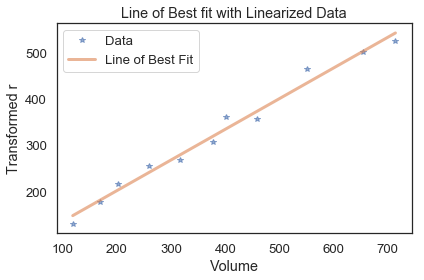

In [4]:
#Calculate a linear best fit line for the transformed data
x = r_vs_volume_transformed_data['Volume']
y = r_vs_volume_transformed_data['Transformed r']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)


#Create the line from calculated slope and intercept
def r_linear_function(slope, intercept, volume):
    r = slope * volume + intercept
    return r

r_plot = r_linear_function(slope, intercept, r_vs_volume_transformed_data['Volume'])

#Plot the linear regression
def plot_linear_on_data(r_plot):
    plot(r_vs_volume_transformed_data['Volume'], r_vs_volume_transformed_data['Transformed r'], '*', label = "Data")
    plot(r_vs_volume_transformed_data['Volume'], r_plot, label = "Line of Best Fit")
    decorate(xlabel = 'Volume', ylabel = 'Transformed r', title = "Line of Best fit with Linearized Data")  

plot_linear_on_data(r_plot)

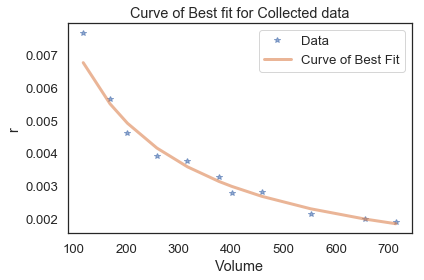

In [5]:
#Delinearizes the data and the line of best fit to give the best fit curve, returns the curve.
def unflipper(r_linear_function, slope, intercept, volume):
    r = r_linear_function(slope, intercept, volume) ** -1
    return r

r_nonlinear_function = unflipper(r_linear_function, slope, intercept, r_vs_volume_transformed_data['Volume'])

#Plots the curve of best fit with the data collected
def plot_nonlinear_on_data(r_nonlinear_function):
    plot(r_vs_volume_data['Volume'], r_vs_volume_data['r'], '*', label = "Data")
    plot(r_vs_volume_data['Volume'], r_nonlinear_function, label = "Curve of Best Fit")
    decorate(xlabel = 'Volume', ylabel = 'r', title = 'Curve of Best fit for Collected data')

plot_nonlinear_on_data(r_nonlinear_function)

In [33]:
# Function of r using math:
def r_math(V):
    V = round(V, 2)
    if V > 0:
        # size of box:
        x = .13
        
        mass = V*0.001

        # heat transfer coefficient between air and water
        h = 0.09
        # heat capacity of water
        C = 4.184

        # surface area as a function of volume (volume in the equation is in kiloliters, so it
        # needs to be converted to milliliters)
        SA = 2*(x**2) + (4*(V* 0.000001))/x

        # mathematical function of r
    else:
        # size of box:
        x = .13

        mass = .001

        # heat transfer coefficient between air and water
        h = 0.09
        # heat capacity of water
        C = 4.184

        # surface area as a function of volume (volume in the equation is in kiloliters, so it
        # needs to be converted to milliliters)
        SA = 2*(x**2) + (4*(V* 0.000001))/x

        # mathematical function of r
    return ((h*SA)/(C*mass))

0.0018736211207530517

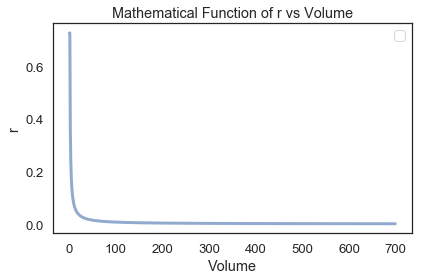

In [34]:
# Visualizing r_math:
listv = []
listr = []
for V in range(0, 700):
    listv.append(V)
    listr.append(r_math(V))
    
plot(listv, listr)
decorate(xlabel = 'Volume',
         ylabel = 'r',
         title = 'Mathematical Function of r vs Volume')

listr[600]

# Model

It was assumed that the values would not change drastically between the cooling of water and the cooling of coffee. 

We plotted these numbers and fit a curve to the graph, giving us a graph of r values against volume that we could pull from in our model.


In [61]:
def update_func(state, t, system, dvdt, unflipper, r_linear_function, slope, intercept):
    """Update the thermal transfer model.
    
    State objects:
    Temperature of vessle
    Volume of vessle
    
    t --> time
    T --> Temperature
    
    returns: State object containing the stocks
    """
    unpack(system)
    
    T = state.T
    V = state.V
    
    
    if str(unflipper) == 'unflipper':
        ### Function of r using empirical data
        r = unflipper(r_linear_function, slope, intercept, state.V)
    else:
        ### Function of r using math
        r = unflipper(state.V)
        
    dTdt = -r * (T - T_env)
    # dvdt is passed in as an argument - it is being swept

    if(V>0 and T >25):
        T += dTdt * dt
        V += dvdt * dt
    else:
        V = 0
        T = None
    return State(T=T, V=V)

In [62]:
def run_simulation(system, update_func, dvdt, unflipper, r_linear_function, slope, intercept):
    """Runs a simulation of the system.
    
    Add a TimeFrame to the System: results
    """
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.row[0] = init
    ts = linrange(0, t_end, dt)
    
    # changed unflipper to r_math
    for t in ts:
        frame.row[t+dt] = update_func(frame.row[t], t, system, dvdt, r_math, r_linear_function, slope, intercept)
        
    # store the final temperature in T_final
    system.T_final = get_last_value(frame.T)
    
    return frame

In [81]:
def make_system(T_init, V_init, dvdt):
    """Makes a System object with the given parameters.

    T_init: initial temperature in degC
    r: heat transfer rate - when run, a function of r will be substituted in for it
    t_end: end time of simulation
    T_env: temperature of the environment
    dt: time step
    
    returns: System object
    """
    init = State(T=T_init, V=V_init)
    
    # T_final is used to store the final temperature.
    # Before the simulation runs, T_final = T_init
    # We do the same thing for Volume
    T_final = T_init
    V_final = V_init
    
    T_env = 25
    dt = 1
    
    # n_sweep stands for number of sweeps that the model will perform
    n_sweep = 9
    
    # n_sec stands for number of seconds that the simulation will be run for
    t_end = 600
    # Used at the end of this simulation, this is the threshold that determines
    # what rates of volume change over a given time period will result in a 
    # temperature at or over 40 degrees celcius.
    minimum_acceptable_temp = 40
    
    return System(locals())


In [82]:
system = make_system(85, 700, -1)

,values
minimum_acceptable_temp,40
t_end,600
n_sweep,9
dt,1
T_env,25
V_final,700
T_final,85
init,T 85 V 700 dtype: int64
dvdt,-1
V_init,700


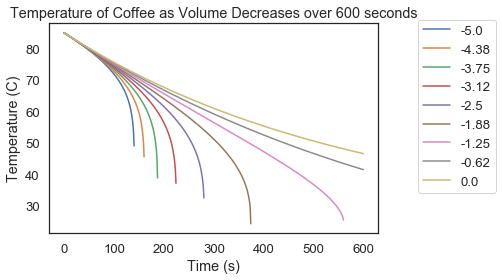

In [94]:
#### Math
def sweepdVdt(system):
    sweep = SweepSeries()
    dvdt_range = linspace(-5,0,system.n_sweep)
    
    for t in range(0, system.n_sweep):
        dvdt = dvdt_range[t]
        sweep[t] = run_simulation(system, update_func, dvdt, r_math, r_linear_function, slope, intercept)

    return sweep

swept = sweepdVdt(system);

dvdt_range = linspace(-5,0,system.n_sweep)
fig = plt.figure()
ax = plt.subplot(111);
for i in range(system.n_sweep):
    dvdt = round(dvdt_range[i], 2)
    ax.plot(swept[i].index, swept[i].T, label = dvdt)
    decorate(xlabel = 'Time (s)',
            ylabel = 'Temperature (C)',
            title = 'Temperature of Coffee as Volume Decreases over {} seconds'.format(system.t_end))
    ax.legend(bbox_to_anchor=(1.1,1.05))

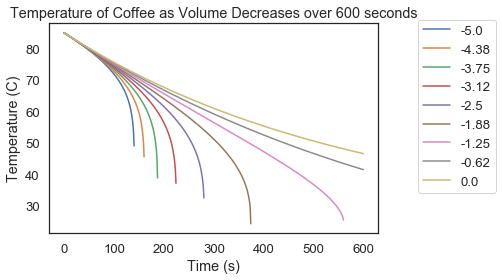

In [96]:
### Emperical

def run_simulation_emp(system, update_func, dvdt, unflipper, r_linear_function, slope, intercept):
    """Runs a simulation of the system.
    
    Add a TimeFrame to the System: results
    """
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.row[0] = init
    ts = linrange(0, t_end, dt)
    
    for t in ts:
        frame.row[t+dt] = update_func(frame.row[t], t, system, dvdt, unflipper, r_linear_function, slope, intercept)
        
    # store the final temperature in T_final
    system.T_final = get_last_value(frame.T)
    
    return frame

def sweepdVdt_emp(system):
    sweep2 = SweepSeries()
    dvdt_range = linspace(-5,0,system.n_sweep)
    
    for t in range(0, system.n_sweep):
        dvdt = dvdt_range[t]
        sweep2[t] = run_simulation(system, update_func, dvdt, unflipper, r_linear_function, slope, intercept)

    return sweep2

swept2 = sweepdVdt_emp(system);

dvdt_range = linspace(-5,0,system.n_sweep)
fig = plt.figure()
ax = plt.subplot(111);
for i in range(system.n_sweep):
    dvdt = round(dvdt_range[i], 2)
    ax.plot(swept2[i].index, swept2[i].T, label = dvdt)
    decorate(xlabel = 'Time (s)',
            ylabel = 'Temperature (C)',
            title = 'Temperature of Coffee as Volume Decreases over {} seconds'.format(system.t_end))
    ax.legend(bbox_to_anchor=(1.1,1.05))

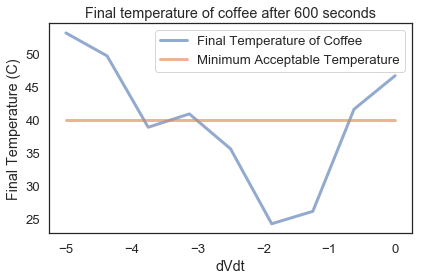

In [93]:
# Creating the time series in which the last temperatures from each dVdt sweep will be stored.
last_temp = TimeSeries()

def determine_last_temp(last_temp, system, swept):
    # Selecting the last values from each sweep by selecting the temperature associated with the point 
    # at which the volume first hits 0 mL. If the volume never reaches 0, the last temperature is still selected. 
    for i in range(system.n_sweep):
        for t in range(system.t_end):
            if (swept[i].V[t] == 0 or t == system.t_end - 1):
                last_temp[i] = swept[i].T[t-1]
                break
    return last_temp

last_temp = determine_last_temp(last_temp, system, swept)

# To plot the data against dVdt and not against the sweep numbers, the dvdt values and last temperature
# values will be converted into lists and then plotted against each other.
dvdt_list = []
last_temp_list = []

for i in range(len(dvdt_range)):
    dvdt_list.append(dvdt_range[i])
    last_temp_list.append(last_temp[i])

def plot_final_temp_and_minimum_acceptable_temp(dvdt_list, last_temp_list, minimum_acceptable_temp):
    plot(dvdt_list, last_temp_list, label = 'Final Temperature of Coffee')
    
    # The minimum acceptable temperature will be plotted as a line. To achieve this, a list of length 
    # len(dvdt_range) will created and contain the minimum acceptable temperature in each index. 
    minimum_acceptable_temp_list = list()
    for i in range(len(dvdt_range)):
        minimum_acceptable_temp_list.append(minimum_acceptable_temp)
    plot(dvdt_list, minimum_acceptable_temp_list, label = 'Minimum Acceptable Temperature')
    return minimum_acceptable_temp_list

plot_final_temp_and_minimum_acceptable_temp = plot_final_temp_and_minimum_acceptable_temp(dvdt_list, last_temp_list, 
                                                                                          minimum_acceptable_temp)
decorate(xlabel = 'dVdt', 
         ylabel = 'Final Temperature (C)', 
         title = 'Final temperature of coffee after {} seconds'.format(system.t_end))

# Results

The model shows that as volume decreases, the rate of change in temperature increases. Over the 5 minutes that our model represents, 

In [17]:
find_math_r(25, surface_area_as_volume, 4184, mass_as_volume, frame.row[t])
#call find_math_r in update_func to get our r values via math

NameError: name 'find_math_r' is not defined